In [1]:
# Imports
# Dataset class
from Act2Act import Act2Act

# Data loader class
from spektral.data.loaders import DisjointLoader

# GIN model
from models import GIN0

# TensorFlow for training the model
import tensorflow as tf

# Optimizer, loss function and accuracy measurements
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import CategoricalCrossentropy

# Numpy for numerical operations
import numpy as np

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Dataset parameters
actions = ["A001", "A005", "A008", "A010"] # Classes used for training
reshaping_mode = "upscale" # Node feature matrix reshaping mode
num_of_feats = 2379 # Number of columns in the node feature matrix, according to the longest sequence

In [3]:
# Generate dataset
dataset = Act2Act(actions=actions, reshaping_mode=reshaping_mode, num_of_feats=num_of_feats)

Proccessing npz data:   0%|          | 0/1999 [00:00<?, ?it/s]

Proccessing npz data: 100%|██████████| 1999/1999 [00:26<00:00, 76.62it/s]


In [8]:
# Dataset parameters
n_feats = dataset.n_node_features # Number of node features in a dataset
n_labels = dataset.n_labels # Number of classes in a dataset

In [12]:
# Model parameters
learining_rate = 0.001 # Learning rate

gin_channels = 128 # Number of hidden channels in GIN model
gin_layers = 3 # Number of layers in GIN model

epochs = 50 # Number of trainig epochs
batch_size = 32 # Batch size

In [13]:
# Train/Test split (80% Train / 20% Test - random split)
dataset_indexes = np.random.permutation(len(dataset))

split_limit = int(0.8 * len(dataset))
train_indexes, test_indexes = np.split(dataset_indexes, [split_limit])
dataset_tr, dataset_te = dataset[train_indexes], dataset[test_indexes]

In [14]:
# Loading training and testing data
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=False)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1, node_level=False)

# Signature of a training loader
loader_tr_signature = loader_tr.tf_signature()

In [15]:
# Building the model
model = GIN0(gin_channels, gin_layers, n_labels)
optimizer = Adam(learining_rate)
loss_fn = CategoricalCrossentropy()

In [16]:
# Training step function
@tf.function(input_signature=loader_tr_signature, experimental_relax_shapes=True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(targets, predictions))

    return loss, acc, predictions

In [17]:
# Training loop
epoch, step = 0, 0
results, all_results = [], [] # Empty lists for keeping track of results in epoch and in the whole training loop
labels_batch, preds_batch = [], [] # Lists for storing actual and predicted labels for each prediction made in an epoch

# Iterating over batches
for batch in loader_tr:
    step +=1
    
    labels_batch.append(batch[1]) # Output from a batch is a tuple
    loss, acc, preds = train_step(*batch) # Making prediction

    results.append((loss, acc))
    preds_batch.append(preds)

    # Getting overall trainig results in an epoch
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1
        epoch_loss, *epoch_acc = np.mean(results, 0)
        all_results.append((epoch_loss, epoch_acc))
        results = [] # Resetting results for each epoch

        print(f"Epoch: {epoch} | Loss: {epoch_loss} | Acc: {epoch_acc}")

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'Act2Act' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch: 1 | Loss: 0.5930326581001282 | Acc: [0.70610887]
Epoch: 2 | Loss: 0.3723258972167969 | Acc: [0.8218346]
Epoch: 3 | Loss: 0.27914178371429443 | Acc: [0.8743145]
Epoch: 4 | Loss: 0.2562761604785919 | Acc: [0.89927423]
Epoch: 5 | Loss: 0.1900104135274887 | Acc: [0.9337096]
Epoch: 6 | Loss: 0.206619992852211 | Acc: [0.921875]
Epoch: 7 | Loss: 0.22351974248886108 | Acc: [0.9199799]
Epoch: 8 | Loss: 0.18702098727226257 | Acc: [0.93745965]
Epoch: 9 | Loss: 0.16712439060211182 | Acc: [0.9424395]
Epoch: 10 | Loss: 0.1629466414451599 | Acc: [0.94060487]
Epoch: 11 | Loss: 0.15206556022167206 | Acc: [0.94495964]
Epoch: 12 | Loss: 0.12881170213222504 | Acc: [0.95497984]
Epoch: 13 | Loss: 0.13450878858566284 | Acc: [0.95058465]
Epoch: 14 | Loss: 0.15650229156017303 | Acc: [0.9486492]
Epoch: 15 | Loss: 0.1134737879037857 | Acc: [0.958125]
Epoch: 16 | Loss: 0.15007565915584564 | Acc: [0.949375]
Epoch: 17 | Loss: 0.1083911806344986 | Acc: [0.964375]
Epoch: 18 | Loss: 0.10579883307218552 | Acc: [

In [18]:
# Testing loop
test_results = []

# Iterating over testing data
for batch in loader_te:
    test_input, test_labels = batch # Unpacking batch tuple

    test_prediction = model(test_input, training=False)

    # Calculating loss and accuracy
    test_loss = loss_fn(test_labels, test_prediction)
    test_acc = tf.reduce_mean(categorical_accuracy(test_labels, test_prediction))


    # Keeping track of results and printing them
    test_results.append((test_loss, test_acc))
    print(f"Test | Loss: {test_loss} | Acc: {test_acc}")

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'Act2Act' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Test | Loss: 0.07409347593784332 | Acc: 0.96875
Test | Loss: 0.2027565836906433 | Acc: 0.9375
Test | Loss: 0.10892704129219055 | Acc: 0.9375
Test | Loss: 0.11233475804328918 | Acc: 0.9375
Test | Loss: 0.19420528411865234 | Acc: 0.875
Test | Loss: 0.2991795241832733 | Acc: 0.90625
Test | Loss: 0.17426343262195587 | Acc: 0.96875
Test | Loss: 0.09461601823568344 | Acc: 0.96875
Test | Loss: 0.07764405012130737 | Acc: 0.96875
Test | Loss: 0.14168846607208252 | Acc: 0.9375
Test | Loss: 0.10427748411893845 | Acc: 0.9375
Test | Loss: 0.02833242155611515 | Acc: 1.0
Test | Loss: 0.016830358654260635 | Acc: 1.0


In [19]:
# Plotting training results
epoch_axis = [i for i in range(1, epochs+1)] # x-axis with a length equal to num of epochs
training_loss, training_acc = list(map(list, zip(*all_results))) # Un zipping list of tuples containing loss and accuracy for each epoch

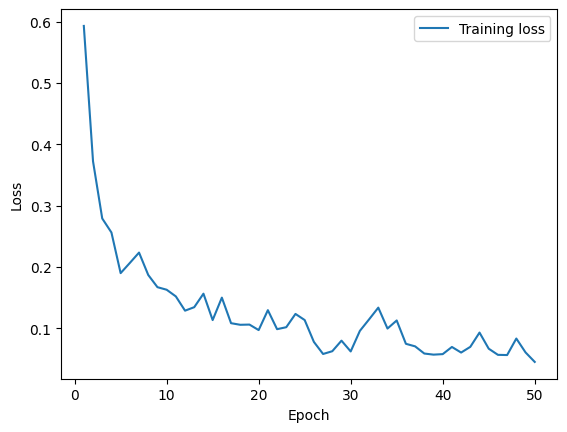

In [20]:
# Plotting loss over epochs
plt.plot(epoch_axis, training_loss)
plt.legend(["Training loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

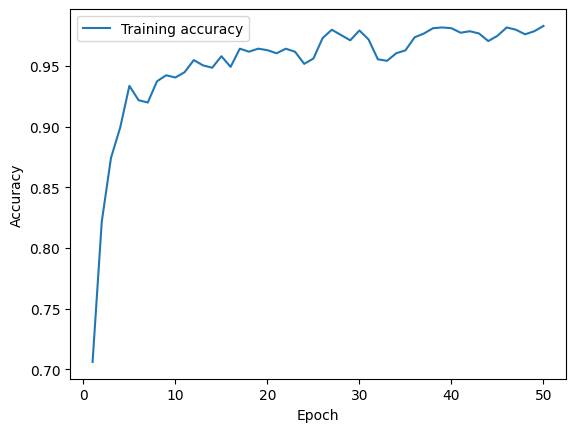

In [21]:
# Plotting accuracy over epochs
plt.plot(epoch_axis, training_acc)
plt.legend(["Training accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [23]:
cm_list = [] # List of all confusion matrices in all epochs

# Iterating over length of labels_batch
for n_batch in range(len(labels_batch)):
    batch_labels = labels_batch[n_batch] # Loading labels for a n_batch batch
    batch_predictions = tf.argmax(preds_batch[n_batch], axis=-1) # Getting index of maximum value element in each prediction vector

    n = len(batch_labels)

    batch_y_lst = [list(batch_labels[i]).index(1) for i in range(n)]
    batch_pred_lst = [batch_predictions[i]._numpy().astype(int) for i in range(n)]

    # Adding confusion matrix from an epoch to a list
    cm_list.append(tf.math.confusion_matrix(batch_y_lst, batch_pred_lst, dtype = tf.int64))

In [27]:
# Converting confusion matrices in a list to numpy arrays
for i in range(len(cm_list)):
    cf_mat = cm_list[i].numpy()
    cm_list[i] = cf_mat

In [30]:
# Checking if there are any confusion matrices with wrong dimensions
for i in range(len(cm_list)):
    if cm_list[i].shape != (n_labels,n_labels):
        print(f"Index of a wrong matrix: {i}")
        print(f"Wrong matrix: {cm_list[i]}")

In [32]:
# Creating empty confusion matrix
cm_empty = np.zeros((n_labels, n_labels))

# Adding all confusion matrices together
for i in range(len(cm_list)):
    cm_empty += cm_list[i]


# Creating final confusion matrix
train_confusion_matrix = cm_empty.astype(int)

# Printing number of total predictions made by model
print(np.sum(train_confusion_matrix))

79950


<Axes: >

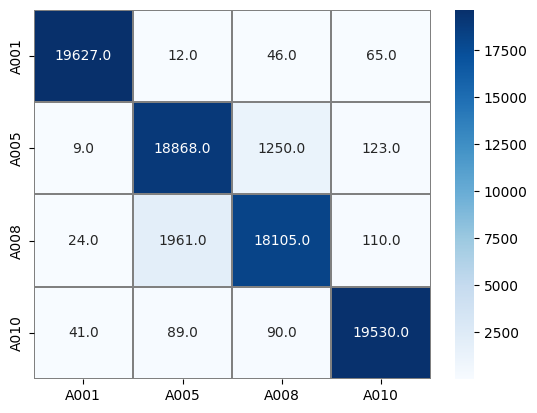

In [33]:
# Plotting confusion matrix as a seaborn heatmap
x_labels = actions
y_labels = actions

sns.heatmap(train_confusion_matrix, xticklabels=x_labels, yticklabels=y_labels, cmap="Blues", linecolor="gray", linewidths=0.008, annot=True, fmt=".1f" )